In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np 
import time
import random
from collections import deque
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import Sequential 
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import math
import PIL.Image
from tensorflow.keras import backend as K
import cv2
import segmentation_models as sm
from IPython import display
import copy
from skimage.color import rgb2gray
import random
import gc
from sklearn.preprocessing import MinMaxScaler
import concurrent.futures



2024-04-17 20:56:54.560963: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 20:56:54.583332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 20:56:54.583357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 20:56:54.583967: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 20:56:54.587888: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


2024-04-17 20:56:55.721151: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 20:56:55.743725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 20:56:55.743891: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
s="BraTS20_Training_001flair_slice10.png"
s.split("flair")[0][-3:]

'001'

In [4]:
N_IMAGES=1001

In [5]:
img_path=r'/home/bhavik/Desktop/Pratik/brats_dataset/images/brats2020flair/'
mask_path=r'/home/bhavik/Desktop/Pratik/brats_dataset/masks/brats2020mask/'

In [6]:
images=[]
masks=[]

In [7]:
def get_images(img_path=img_path,mask_path=mask_path,number=5000,threshold=0.1,patient_number_lower=00,patient_number_higher=300):
    #storing 5000 images and masks in the lists images and masks. Only storing those images in which masked region is greater than 1% 
    #and combining different mask calsses into one
    images=[]
    masks=[]
    grays=[]
    for root, dirs, files in os.walk(img_path,mask_path):
        print(len(files))
        for i,name in enumerate(files):
            image_path = img_path+name
            msk_path=mask_path+name.replace("flair","seg")
            if patient_number_lower<=int(image_path.split("flair")[1][-3:])<=patient_number_higher:
                try:
                    image = PIL.Image.open(image_path)
                    mask=PIL.Image.open(msk_path)
                    # Convert the mask to grayscale.
                    gray_mask = np.mean(mask.convert('RGB'), axis=2)
                    # Resize the mask to 240x240x1.
                    
                    resized_mask = np.resize(gray_mask, (240, 240,1))
                    val, counts = np.unique(resized_mask, return_counts=True)
                    if (1 - (counts[0]/counts.sum())) > threshold:
                        images.append(np.array(image.convert('RGB'))/255)
                        masks.append(np.array(resized_mask)/255)
                        grays.append(rgb2gray(np.array(image.convert('RGB'))/255))
                except:
                    continue
                if len(images)==number-1:
                    break
            else:
                continue
    images_array=np.array(images)
    masks_array=np.array(masks)
    bw_images_array=np.array(grays)
    unique_values=np.unique(masks_array[:100])
    masks_array[masks_array==unique_values[1]]=1
    masks_array[masks_array==unique_values[2]]=1

    del images,masks
    return images_array,masks_array,bw_images_array

In [8]:
images_array, masks_array,bw_images_array=get_images(img_path=img_path,mask_path=mask_path,number=N_IMAGES,threshold=0.05,patient_number_lower=00,patient_number_higher=200)

57196


In [9]:
test_images_array, test_masks_array,test_bw_images_array=get_images(img_path=img_path,mask_path=mask_path,number=201,threshold=0.01,patient_number_lower=201,patient_number_higher=350)

57196


In [10]:
images_array.shape

(1000, 240, 240, 3)

In [11]:
test_images_array.shape

(200, 240, 240, 3)

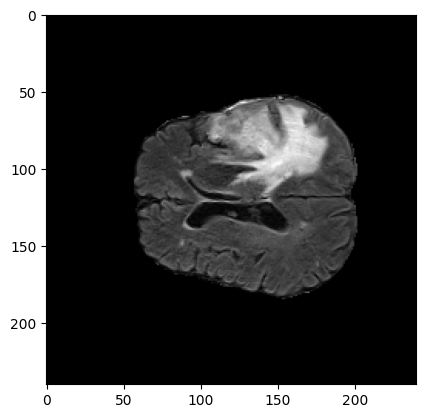

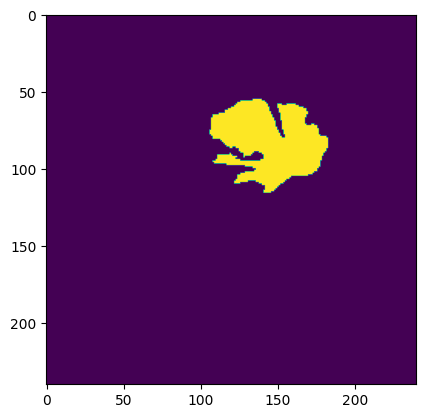

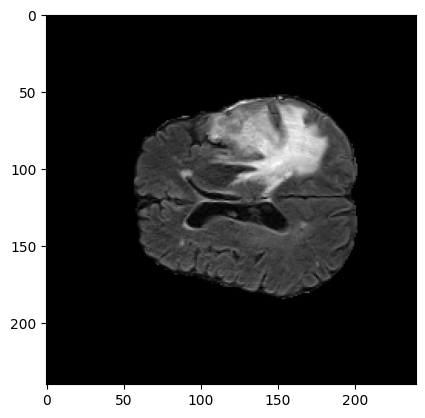

In [12]:
plt.imshow(images_array[0])
plt.show()
plt.imshow(masks_array[0])
plt.show()
plt.imshow(bw_images_array[0],cmap='gray')

In [13]:
val, counts = np.unique(masks_array[0], return_counts=True)
print(val)
print(counts)

[0. 1.]
[54704  2896]


In [14]:
#converting mask class to one hot encoded vector
from keras.utils import to_categorical
masks_cat = to_categorical(masks_array, num_classes=2)
test_masks_cat = to_categorical(test_masks_array, num_classes=2)

print(masks_cat.shape)
print(test_masks_cat.shape)

(1000, 240, 240, 2)
(200, 240, 240, 2)


In [15]:
# #train test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test,bw_train,bw_test = train_test_split(images_array, masks_cat, bw_images_array, test_size = 0.25, shuffle=False,stratify=None)

In [16]:
X_train=images_array
y_train=masks_cat
bw_train=bw_images_array
X_test=test_images_array
y_test=test_masks_cat
bw_test=test_bw_images_array

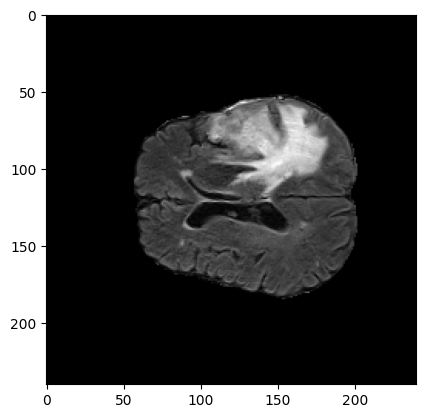

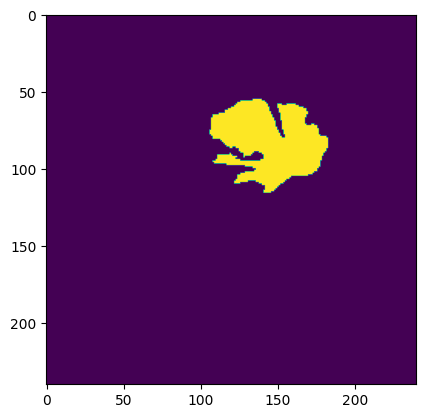

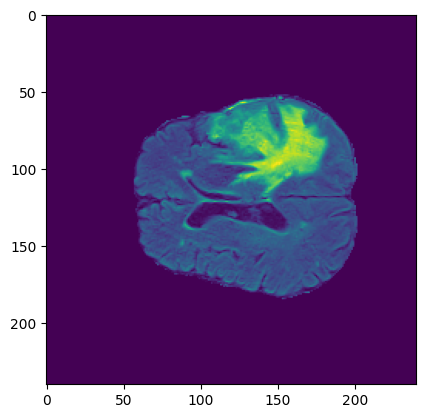

In [17]:
plt.imshow(X_train[0])
plt.show()
plt.imshow(masks_array[0])
plt.show()
plt.imshow(bw_train[0])
plt.show()

In [18]:
bw_test.shape

(200, 240, 240)

In [19]:
IMG_HEIGHT = images_array.shape[1]
IMG_WIDTH  = images_array.shape[2]
IMG_CHANNELS = images_array.shape[3]
print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)

240
240
3


# RL Model

In [20]:
GAMMA = 0.99
LEARNING_RATE = 0.1e-8

MEMORY_SIZE = 5000
BATCH_SIZE = 128

EPSILON_MAX = 1.0
EPSILON_MIN = 0.01
EXPLORATION_DECAY = 0.99

In [21]:
state_space=10 #10 dimensional state space
action_space=3 #3 action [-0.1,0,0.1]
all_actions=[-0.1,0,0.1]
intermediate_dim=16

In [22]:
class QModel:
    def __init__(self, input_dim, output_dim, lr):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lr = lr
        self.Qpolicy = self.create()
        self.Qtarget = self.create() 
        self.Qtarget.set_weights(self.Qpolicy.get_weights())
        
    def create(self):
        model = Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(1,state_space)))
        model.add(Dense(512,activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(self.output_dim, activation = 'linear'))
        model.compile(optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=self.lr), loss = "mse", metrics = ['accuracy'])
        return model

In [23]:
class DQNSolver:
    def __init__(self,state_space,action_space, decay_coe = 0.99, 
                  memory_size = MEMORY_SIZE,EXPLORATION_DECAY=EXPLORATION_DECAY,LEARNING_RATE=LEARNING_RATE,EPSILON_MAX=EPSILON_MAX,EPSILON_MIN=EPSILON_MIN,BATCH_SIZE=BATCH_SIZE):
        
        #self.env = gym.make('CartPole-v0')

        self.states = state_space
        self.n_actions = action_space
        
        self.actions = [i for i in range(self.n_actions)]
        
        self.lr = LEARNING_RATE
        self.gamma = GAMMA
        self.epsilon = EPSILON_MAX
        self.decay_coe = decay_coe
        self.min_eps = EPSILON_MIN
        #self.episodes = episodes
        self.batch_size = BATCH_SIZE
        self.memory = deque(maxlen = memory_size) # replay memory 
        
        self.terminal_state = False # end of the episode
        self.target_counter = 0 
        self.exploration_decay=EXPLORATION_DECAY
        # Plot data
        #self.timestep = self.episodes / 10

        
        
        
        self.model = QModel((1,self.states), self.n_actions, self.lr)
        # Smooth epsilon 
        # self.a = 0.35
        # self.b = 0.1
        # self.c = 0.01
        
    def state_shape(self,states):
        states = np.array(states)
        return states.reshape(-1,*states.shape)
    def update_target_model(self):
        """
        Updates the current target_q_net with the q_net which brings all the
        training in the q_net to the target_q_net.
        :return: None
        """
        self.model.Qtarget.set_weights(self.model.Qpolicy.get_weights())
    def decrement_epsilon(self):
        '''
        if self.epsilon > self.min_eps:
            self.epsilon *= self.decay_coe
        else:
            self.epsilon = self.min_eps
        '''
        # s_time = (time - self.a*self.episodes) / (self.b*self.episodes) 
        # cosh = np.cosh(math.exp(-s_time))
        # self.epsilon = 1 - (1/cosh + (time*self.c/self.episodes))
        if self.epsilon>self.min_eps:
            self.epsilon*=self.exploration_decay
        else:
            self.epsilon=self.min_eps
    def forget(self):
        self.memory.clear()

    def remember(self, s, a, r, s_, done):
        self.memory.append([self.state_shape(s), a, r, self.state_shape(s_), done])
        
    def act(self, states):
        if np.random.random() > (1 - self.epsilon):
            action = np.random.choice(self.actions)
        else:
            states = self.state_shape(states)
            states.reshape(1,1,self.states)
#             states=[states]
#             states=np.array(states)
            #print(states.shape)
            action = np.argmax(np.array(self.model.Qpolicy.predict_on_batch(states)))
            
        return action
            
    def minibatch(self):
        return random.sample(self.memory, self.batch_size)
        
    

        #plt.savefig(r'RL/loss - e{}v2.png'.format(episode), dpi = 500)
        
    def train(self):
        # X - states passed to the NN, y - target
        
        X, y = [], []
        
        if len(self.memory) >= self.batch_size: 
            SARS = self.minibatch()
            s =np.array( [row[0] for row in SARS])
            s=s.reshape(BATCH_SIZE,1,state_space)
            #print(s.shape)
            qvalue = np.array(self.model.Qpolicy.predict_on_batch(s))
            #print(qvalue)
            s_ =np.array( [row[3] for row in SARS])
            s_=s_.reshape(BATCH_SIZE,1,state_space)
            future_qvalue = np.array(self.model.Qtarget.predict_on_batch(s_))
            #print("2")
            #print(future_qvalue)

            for index, (state, action, reward, state_, done) in enumerate(SARS):
                if done == True:
                    Qtarget = reward
                else:
                    Qtarget = reward + self.gamma * np.max(future_qvalue[index][0])
            
                qcurr = qvalue[index][0]
                #print(qcurr)
                qcurr[int(action)] = Qtarget 
                #print(qcurr)
                X.append(state)
                y.append(qcurr)
#             X_dataset=tf.data.Dataset.from_tensor_slices(X).batch(64)
#             y_dataset=tf.data.Dataset.from_tensor_slices(y).batch(64)
#             final_dataset=tf.data.Dataset.zip((X_dataset, y_dataset))
            X, y = np.array(X).reshape(self.batch_size,1,self.states), np.array(y).reshape(self.batch_size, 1, self.n_actions)
                                 
            loss = self.model.Qpolicy.train_on_batch(X, y,return_dict=True)
            
            

In [24]:
dqn_solver=DQNSolver(state_space=state_space,action_space=action_space)


2024-04-17 20:57:36.308059: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 20:57:36.308203: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-17 20:57:36.308255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [25]:

def step(state,action,ground_truth):
    #step function to get new state and reward based on action taken and current state
    # new_state=[]
    all_actions=[-0.1,0,0.1]
    new_state=list(copy.deepcopy(state))
    # print(action)
    # print(all_actions[action])
    # print("before ",new_state)
    new_state[9]=(max(min(new_state[9]+all_actions[action],1),0))
    # print("after ",new_state)
    # if (new_state[9]==ground_truth) :
    #     reward=1
    # else:
    #     reward=-(ground_truth-new_state[9])**2
    if ((ground_truth-state[9])**2-(ground_truth-new_state[9])**2) >0.001:
        reward=0.1
    elif (((ground_truth-state[9])**2-(ground_truth-new_state[9])**2)<=0.001)and(((ground_truth-state[9])**2-(ground_truth-new_state[9])**2)>=-0.001):
        reward=0
    else:
        reward=-0.1
    # reward=(ground_truth-state[4])**2-(ground_truth-new_state[4])**2 
    #reward function based on if the action taken changes probability of the class 1 towards the ground truth or not
    return [new_state,reward]
    

In [26]:
#function to get state from image pixel
def get_state(i,j,predicted_prob,bw_image):
    height=len(bw_image)
    width=len(bw_image[0])
    state=[]
    if i>0 and i< height-1:
        if j>0 and j<width-1:
            state.extend(bw_image[i-1,j-1:j+2].reshape(3,))
            state.extend(bw_image[i,j-1:j+2].reshape(3,))
            state.extend(bw_image[i+1,j-1:j+2].reshape(3,))
        elif j==0:
            state.extend([0])
            state.extend(bw_image[i-1,j:j+2].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i,j:j+2].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i+1,j:j+2].reshape(2,))
        else:
            state.extend(bw_image[i-1,j-1:j+1].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i,j-1:j+1].reshape(2,))
            state.extend([0])
            state.extend(bw_image[i+1,j-1:j+1].reshape(2,))
            state.extend([0])
    else:
        if i==0:
            if j>0 and j<width-1:
                state.extend([0,0,0])
                state.extend(bw_image[i,j-1:j+2].reshape(3,))
                state.extend(bw_image[i+1,j-1:j+2].reshape(3,))
            elif j==0:
                state.extend([0,0,0])
                state.extend([0])
                state.extend(bw_image[i,j:j+2].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i+1,j:j+2].reshape(2,))
            else:
                state.extend([0,0,0])
                state.extend(bw_image[i,j-1:j+1].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i+1,j-1:j+1].reshape(2,))
                state.extend([0])
        else:
            if j>0 and j<width-1:
                state.extend(bw_image[i-1,j-1:j+2].reshape(3,))
                state.extend(bw_image[i,j-1:j+2].reshape(3,))
                state.extend([0,0,0])
            elif j==0:
                state.extend([0])
                state.extend(bw_image[i-1,j:j+2].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i,j:j+2].reshape(2,))
                state.extend([0,0,0])
            else:
                state.extend(bw_image[i-1,j-1:j+1].reshape(2,))
                state.extend([0])
                state.extend(bw_image[i,j-1:j+1].reshape(2,))
                state.extend([0])
                state.extend([0,0,0])
    # state.append(predicted_img[i][j])
    # scaled_state=list(MinMaxScale(state))
    state.append(predicted_prob[i][j])
    return np.array(state).reshape(10,)


        



# HELPER FUNCTIONS

In [27]:
# def get_bounding_box(img):
# #get bounding box accros tumor segmentation
#     left=240
#     top=0
#     right=0
#     bottom=0
#     top_flag=0
    
#     for i in range(len(img)):
#         forward=list(img[i])
#         reverse=list(img[i])
#         reverse.reverse()
#         if (np.max(img[i])!=0 and top_flag==0):
#             top=i
#             top_flag=1
#         if np.max(img[i])!=0:
#             bottom=i
#             if  forward.index(1)<left:
#                 left=forward.index(1)
#             if len(reverse)-reverse.index(1)-1>right:
#                 right=len(reverse)-reverse.index(1)-1
        
#     del forward
#     del reverse
#     return left, top, right, bottom




In [28]:
def get_bounding_box(img):
#get bounding box accros tumor segmentation
    left=240
    top=0
    right=0
    bottom=0
    top_flag=0
    
    for i in range(len(img)):
        forward=list(img[i])
        reverse=list(img[i])
        reverse.reverse()
        if (np.max(img[i])!=0 and top_flag==0):
            top=i
            top_flag=1
        if np.max(img[i])!=0:
            bottom=i
            for k in range(len(forward)):
                if forward[k]!=0:
                    if k<left:
                        left=k 
                    break
            for k in range(len(reverse)):
                if reverse[k]!=0:
                    if len(reverse)-k-1>right:
                        right=len(reverse)-k-1
                    break
            
        
    del forward
    del reverse
    return left, top, right, bottom

57 52 201 184


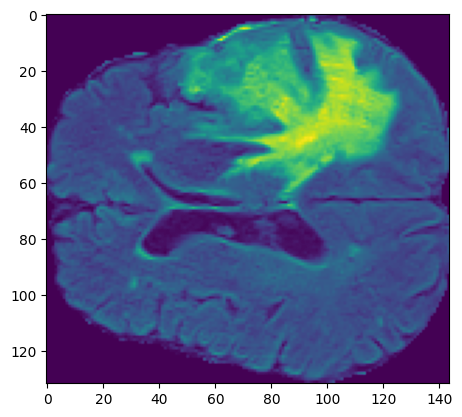

In [29]:
left, top, right, bottom=get_bounding_box(bw_train[0])
print(left, top, right, bottom)
plt.imshow(bw_train[0][top:bottom,left:right])

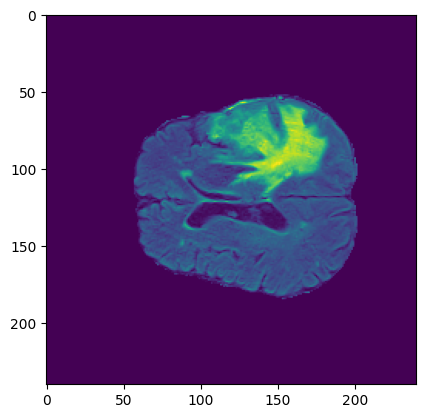

In [30]:
plt.imshow(bw_train[0])

In [31]:
bw_train.shape

(1000, 240, 240)

In [32]:
def cropping(indices,predicted_probs_images,X_images=X_train,y_images=y_train,bw_images=bw_train,cushion=0):
    #to get cropped images, masks and predictions based on segmentation by Unet
    cropped_images=[]
    cropped_masks=[]
    cropped_predictions=[]
    cropped_predicted_imgs=[]
    predicted_imgs=[]
    cropped_bw_images=[]
    for i in indices:
        cushion=cushion
        left=240
        top=0
        right=0
        bottom=0
        # prediction = (unet_model.predict(np.expand_dims(X_images[i],0),verbose=0))
        # predicted_img=np.argmax(prediction, axis=3)[0,:,:]
        # predicted_imgs.append(predicted_img)
        left, top, right, bottom=get_bounding_box(bw_images[i])
        left=max(left-cushion,0)
        right=min(right+cushion,IMG_WIDTH)
        top=max(0,top-cushion)
        bottom=min(bottom+cushion,IMG_HEIGHT)
        cropped_prediction=predicted_probs_images[i][top:bottom,left:right]
        cropped_predictions.append(cropped_prediction)
        cropped_bw_image=bw_images[i][top:bottom,left:right]
        cropped_bw_images.append(cropped_bw_image)
        # cropped_predicted_img=predicted_img[top:bottom,left:right]
        cropped_image=X_images[i][top:bottom,left:right]
        cropped_mask=np.argmax(y_images[i], axis=-1)[top:bottom,left:right]
        cropped_images.append(cropped_image)
        cropped_masks.append(cropped_mask)
        # cropped_predicted_imgs.append(cropped_predicted_img)
        # display.clear_output(wait=True)
    return cropped_images,cropped_masks,cropped_predictions,cropped_bw_images

# Final Training Loop

In [33]:

DQN_TRAINING_SAMPLE_SIZE=500
CUSHION=0

In [34]:
predicted_probs_images=np.zeros((len(X_train),IMG_HEIGHT,IMG_WIDTH))
# predicted_probs_images=np.random.randint(10,size=(len(X_train),IMG_HEIGHT,IMG_WIDTH))/10
predicted_probs_images.shape

(1000, 240, 240)

In [35]:
def dqn_training_with_loop(rewards_array,cropped_images,cropped_predictions,cropped_masks,cropped_bw_images,all_actions,loops=5):
    action_images=[]
    
    for loop in range(loops):
        reward_array_per_img=[]
        for n in range(len(cropped_images)):
            reward_sum=0
            x=np.array(dqn_solver.model.Qpolicy.weights[0][0])
            if math.isnan(x[0]):
                print("NaN Encountered")
                break
            print(f"loop:{loop}, image:{n}")
            
            action_image=[]
            for i in range(len(cropped_images[n])):
                actions_temp=[]
                for j in range(len(cropped_images[n][i])):
                    state=get_state(i,j,cropped_predictions[n],cropped_bw_images[n])
                    action=dqn_solver.act(state)
                    
                    # actions_temp.append(all_actions[action])
                    new_state,reward=step(state,action,cropped_masks[n][i][j])
                    cropped_predictions[n][i][j]=new_state[9]
                    reward_sum+=reward
                    # cropped_predicted_imgs[n][i][j]=new_state[-1]
                    dqn_solver.remember(state,action,reward,np.array(new_state),False)
                # if i%2==0:
                dqn_solver.train()
                    

                # action_image.append(actions_temp)
            dqn_solver.decrement_epsilon()
            dqn_solver.update_target_model()
            # action_images.append(action_image)
            dqn_solver.forget()
            display.clear_output(wait=True)
            reward_array_per_img.append(reward_sum)
            gc.collect()
        rewards_array.append(reward_array_per_img)
    # return rewards_array
    
    

In [36]:
# with tf.device('CPU'):
#     X_train_unet=tf.data.Dataset.from_tensor_slices(X_train).batch(BATCH_SIZE_UNET)
#     y_train_unet=tf.data.Dataset.from_tensor_slices(tf.cast(y_train,tf.float32)).batch(BATCH_SIZE_UNET)
#     final_unet_dataset=tf.data.Dataset.zip((X_train_unet,y_train_unet))
# del X_train_unet
# del y_train_unet

In [37]:
# rewards_array=[]
# for _ in range(3):
#     indices=random.sample([u for u in range(len(X_train))], DQN_TRAINING_SAMPLE_SIZE)
#     cropped_images,cropped_masks,cropped_predictions,cropped_bw_images=cropping(indices,predicted_probs_images,X_train,y_train,bw_train,cushion=CUSHION)
#     dqn_solver.epsilon=1
#     dqn_training_loop(rewards_array,cropped_images,cropped_predictions,cropped_masks,cropped_bw_images,all_actions,loops=5)

In [38]:
np.random.random()

0.9959247409604979

In [39]:
def for_each_image(x):
    dqn_solver=x[0]
    cropped_prediction=x[1]
    cropped_bw_image=x[2]
    cropped_mask=x[3]
    index=x[4]

    
    print(index)
    reward_sum=0
    for i in range(len(cropped_bw_image)):
            actions_temp=[]
            for j in range(len(cropped_bw_image[i])):
                state=get_state(i,j,cropped_prediction,cropped_bw_image)
                action=dqn_solver.act(state)
                
                new_state,reward=step(state,action,cropped_mask[i][j])
                reward_sum+=reward
                cropped_prediction[i][j]=new_state[-1]
                if np.random.random()<0.3:                    
                    dqn_solver.remember(state,action,reward,np.array(new_state),False)
                else:
                    if cropped_mask[i][j]>0.5:
                     
                        dqn_solver.remember(state,action,reward,np.array(new_state),False)
            # if i%2==0:
            dqn_solver.train()
            
    dqn_solver.decrement_epsilon()
    # dqn_solver.update_target_model()
    return cropped_prediction,reward_sum,index

In [40]:
def dqn_training_loop_multi_threading(rewards_array,cropped_images,cropped_predictions,cropped_masks,cropped_bw_images,all_actions):
    reward_array_per_img=[]
    reward_sum=0
    all=[]
    for p in range(len(cropped_bw_images)):
        all.append([dqn_solver,cropped_predictions[p],cropped_bw_images[p],cropped_masks[p],p])
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        futures=[executor.submit(for_each_image,x) for x in all]
        results=[future.result() for future in concurrent.futures.as_completed(futures)]
    dqn_solver.update_target_model()
    for k,results in enumerate(results):
        index=results[2]
        cropped_predictions[int(index)]=results[0]
        reward_sum+=results[1]
        reward_array_per_img.append(results[1])
    rewards_array.append(reward_array_per_img)
    print(reward_sum)   

In [41]:
def dqn_training_loop(rewards_array,cropped_images,cropped_predictions,cropped_masks,cropped_bw_images,all_actions):
    action_images=[]
    reward_array_per_img=[]
    reward_sum=0
    for n in range(len(cropped_images)):
        print(reward_sum)
        reward_sum=0
        x=np.array(dqn_solver.model.Qpolicy.weights[0][0])
        if math.isnan(x[0]):
            print("NaN Encountered")
            break
        # print(f"image {n}")
        print(f"image:{n}")
        action_image=[]
        for i in range(len(cropped_images[n])):
            actions_temp=[]
            for j in range(len(cropped_images[n][i])):
                state=get_state(i,j,cropped_predictions[n],cropped_bw_images[n])
                action=dqn_solver.act(state)
                
                actions_temp.append(all_actions[action])
                new_state,reward=step(state,action,cropped_masks[n][i][j])

                reward_sum+=reward
                cropped_predictions[n][i][j]=new_state[-1]
                if np.random.random()<0.4:                    
                    dqn_solver.remember(state,action,reward,np.array(new_state),False)
                else:
                    if cropped_masks[n][i][j]>0.5:
                     
                        dqn_solver.remember(state,action,reward,np.array(new_state),False)
            # if i%2==0:
            dqn_solver.train()
                

            action_image.append(actions_temp)
        dqn_solver.decrement_epsilon()
        dqn_solver.update_target_model()
        # action_images.append(action_image)
        # dqn_solver.forget()
        
        display.clear_output(wait=True)
        reward_array_per_img.append(reward_sum)
    rewards_array.append(reward_array_per_img)
    # return action_images,reward_array_per_img
    
    

In [42]:
rewards_array=[]
all_indices=[]

In [43]:
cropped_images,cropped_masks,cropped_predictions,cropped_bw_images=cropping([0],predicted_probs_images,X_train,y_train,bw_train,cushion=CUSHION)
# dqn_training_loop(rewards_array,cropped_images,cropped_predictions,cropped_masks,cropped_bw_images,all_actions)


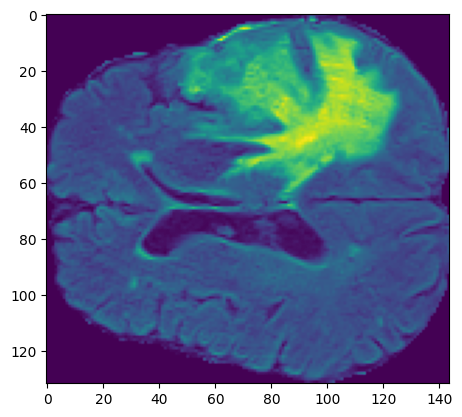

In [44]:
plt.imshow(cropped_bw_images[0])

In [45]:
len(cropped_images[0][1])

144

In [46]:
for t in range(1):
    indices=random.sample([u for u in range(len(X_train))], DQN_TRAINING_SAMPLE_SIZE)
    all_indices.append(indices)
    cropped_images,cropped_masks,cropped_predictions,cropped_bw_images=cropping(indices,predicted_probs_images,X_train,y_train,bw_train,cushion=CUSHION)
    for _ in range(2):
        dqn_solver.epsilon=1
        # dqn_solver.forget()
        # dqn_training_with_loop(rewards_array,cropped_images,cropped_predictions,cropped_masks,cropped_bw_images,all_actions,loops=1)
        # dqn_training_loop(rewards_array=rewards_array,cropped_images=cropped_images,cropped_predictions=cropped_predictions,cropped_masks=cropped_masks,cropped_bw_images=cropped_bw_images,all_actions=all_actions)
        dqn_training_loop_multi_threading(rewards_array=rewards_array,cropped_images=cropped_images,cropped_predictions=cropped_predictions,cropped_masks=cropped_masks,cropped_bw_images=cropped_bw_images,all_actions=all_actions)
        display.clear_output(wait=True)
        # plt.plot(rewards_array[2*t])
        # plt.savefig('rewards_1.jpg')
    # plt.plot(rewards_array[2*t+1])
    # plt.savefig('rewards_2.jpg')


01

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


2024-04-17 20:59:07.269478: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


2024-04-17 21:11:55.060500: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181


2024-04-17 21:35:11.652411: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302


2024-04-17 22:17:19.564415: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362


KeyboardInterrupt: 

363
364
365
366
367
368369
370
371
372
373
374
375
376
377378
379
380
381
382
383
384
385
386
387
388
389390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419


In [47]:
dqn_solver.memory

deque([[array([[0.41960784, 0.42352941, 0.43529412, 0.40784314, 0.41176471,
                0.42745098, 0.4627451 , 0.45490196, 0.45490196, 0.        ]]),
        1,
        0,
        array([[0.41960784, 0.42352941, 0.43529412, 0.40784314, 0.41176471,
                0.42745098, 0.4627451 , 0.45490196, 0.45490196, 0.        ]]),
        False],
       [array([[0.65882353, 0.65490196, 0.61568627, 0.4745098 , 0.49019608,
                0.54117647, 0.39607843, 0.39215686, 0.47058824, 0.        ]]),
        1,
        0,
        array([[0.65882353, 0.65490196, 0.61568627, 0.4745098 , 0.49019608,
                0.54117647, 0.39607843, 0.39215686, 0.47058824, 0.        ]]),
        False],
       [array([[0.17254902, 0.18039216, 0.21176471, 0.10588235, 0.10196078,
                0.17254902, 0.16862745, 0.1254902 , 0.12156863, 0.        ]]),
        1,
        0,
        array([[0.17254902, 0.18039216, 0.21176471, 0.10588235, 0.10196078,
                0.17254902, 0.16862745, 0.1254902 ,

In [48]:
plt.plot(rewards_array[0])
plt.show()
# plt.plot(rewards_array[1])


IndexError: list index out of range

In [ ]:
# for i in range(EPOCHS):
#     print(f"EPOCH: {i}")
#     for _ in range(20):
#         for w in final_unet_dataset:
#             loss=complete_model.train_unet(w[0],w[1])
#         print(loss)
#     # complete_model.unet.fit(X_train, y_train, batch_size=BATCH_SIZE_UNET,
#     #                  epochs=20,validation_data=(X_test, y_test), 
#     #                 shuffle=False)
#     display.clear_output(wait=True)
#     print(f"EPOCH: {i}")
#     print("1")
#     indices=random.sample([u for u in range(len(X_train))], DQN_TRAINING_SAMPLE_SIZE)
#     cropped_images,cropped_masks,cropped_predictions,cropped_predicted_imgs,predicted_imgs,cropped_bw_images=cropping(indices,complete_model.unet,X_train,y_train,bw_train,cushion=CUSHION)
#     print(f"EPOCH: {i}")
#     print("2")
#     print(f"EPOCH: {i}")
#     if i<15:
#         dqn_solver.epsilon=1
#     action_images,reward_array_per_img=dqn_training_loop(cropped_images,cropped_predictions,cropped_predicted_imgs,cropped_masks,cropped_bw_images,all_actions)
#     rewards_array.append(reward_array_per_img)
#     print("3")
#     print(f"EPOCH: {i}")
#     x=np.array(dqn_solver.model.Qpolicy.weights[0][0])
#     if math.isnan(x[0]):
#         print("NaN Encountered")
#         break
#     action_images_final=get_pixelwise_actions(action_images,predicted_imgs,cushion=CUSHION)
    
#     print("4")
#     print(f"EPOCH: {i}")
#     with tf.device('CPU'):
#         X_train_dqn=tf.data.Dataset.from_tensor_slices(np.array([X_train[b] for b in indices])).batch(BATCH_SIZE_UNET)
#         y_train_dqn=tf.data.Dataset.from_tensor_slices(np.array([y_train[b] for b in indices])).batch(BATCH_SIZE_UNET)
#         images_dataset=tf.data.Dataset.from_tensor_slices(action_images_final).batch(BATCH_SIZE_UNET)
#         final_dataset=tf.data.Dataset.zip((X_train_dqn,y_train_dqn,images_dataset))
#     for x in final_dataset:
#         train(complete_model,x[0],x[1],x[2],opt)
#     display.clear_output(wait=True)
#     print(f"EPOCH: {i}")
#     del X_train_dqn
#     del y_train_dqn
#     del images_dataset
#     del final_dataset
#     gc.collect()


# Inference

In [50]:
def dqn_inference_loop(cropped_images,cropped_predictions,cropped_masks,all_actions,cropped_bw_images,loops=5):
    dqn_solver.epsilon==0.01
    action_images=[]
    reward_sum=0
    for m in range(loops):
        for n in range(len(cropped_images)):
            x=np.array(dqn_solver.model.Qpolicy.weights[0][0])
            if math.isnan(x[0]):
                print("NaN Encountered")
                break
            action_image=[]
            for i in range(len(cropped_images[n])):
                actions_temp=[]
                for j in range(len(cropped_images[n][i])):
                    state=get_state(i,j,cropped_predictions[n],cropped_bw_images[n])
                    action=dqn_solver.act(state)
                    actions_temp.append(all_actions[action])
                    new_state,reward=step(state,action,cropped_masks[n][i][j])
                    reward_sum+=reward
                    # dqn_solver.remember(state,action,reward,np.array(new_state),False)
                    # if(abs(reward)>0.01):
                    #     print(reward)
                    cropped_predictions[n][i][j]=max(min(cropped_predictions[n][i][j]+all_actions[action],1),0)
                    # cropped_predictions[n][i][j][0]=max(min(cropped_predictions[n][i][j][0]-all_actions[action],1),0)
                action_image.append(actions_temp)
            if m==0:
                action_images.append(action_image)
            else:
                action_images[n]=np.add(action_images[n],action_image)
            display.clear_output(wait=True)
        print(reward_sum)
    return action_images

    
    

In [51]:
predicted_probs_images_test=np.zeros((len(X_test),IMG_HEIGHT,IMG_WIDTH))
predicted_probs_images_test.shape

(200, 240, 240)

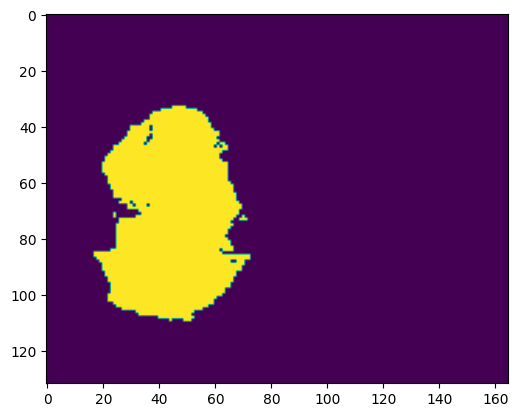

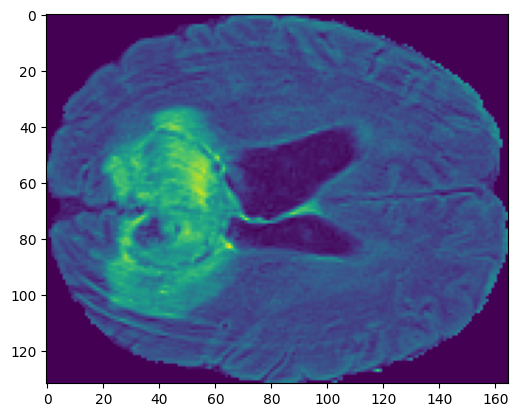

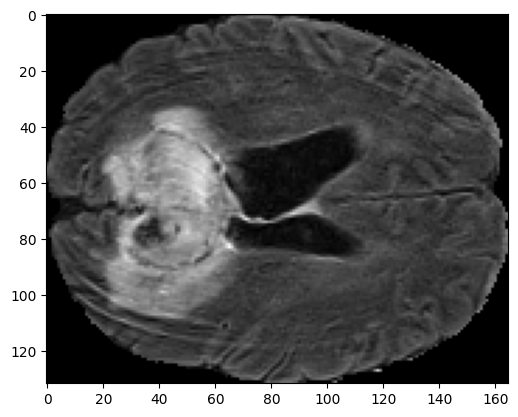

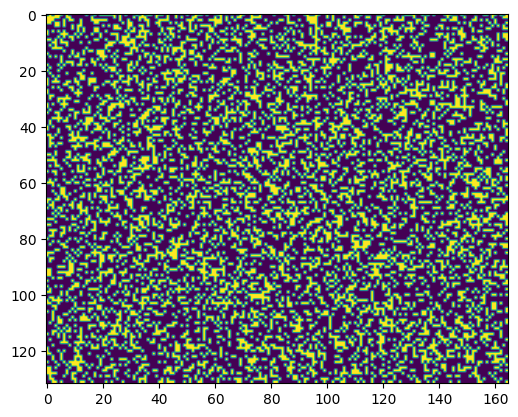

In [52]:
plt.imshow(cropped_masks[4])
plt.show()
plt.imshow(cropped_bw_images[4])
plt.show()
plt.imshow(cropped_images[4])
plt.show()
plt.imshow(cropped_predictions[4])
plt.show()

In [53]:
state=get_state(100,100,cropped_predictions[0],cropped_bw_images[0])
print(state)
step(state,2,1)

[0.60392157 0.56470588 0.55686275 0.57647059 0.56470588 0.56078431
 0.56078431 0.56078431 0.55686275 0.        ]


[[0.6039215686274509,
  0.5647058823529412,
  0.5568627450980392,
  0.5764705882352941,
  0.5647058823529412,
  0.5607843137254902,
  0.5607843137254902,
  0.5607843137254902,
  0.5568627450980392,
  0.1],
 0.1]

In [54]:
state

array([0.60392157, 0.56470588, 0.55686275, 0.57647059, 0.56470588,
       0.56078431, 0.56078431, 0.56078431, 0.55686275, 0.        ])

In [55]:
predicted_probs_images_test=np.zeros((len(X_test),IMG_HEIGHT,IMG_WIDTH))
predicted_probs_images_test.shape

(200, 240, 240)

In [ ]:
# # predicted_probs_images=np.zeros((len(X_train),IMG_HEIGHT,IMG_WIDTH))
# predicted_probs_images_test=np.random.randint(10,size=(len(X_test),IMG_HEIGHT,IMG_WIDTH))/10
# predicted_probs_images_test.shape

In [ ]:
plt.imshow(predicted_probs_images_test[0])
plt.show()

In [ ]:
# dqn_solver.model.Qpolicy.load_weights('RL_model_weights_1000_1_0_4')
# dqn_solver.model.Qtarget.load_weights('RL_model_weights_1000_1_0_4')

In [ ]:
cropping_indices=[0]

In [56]:
cropped_images,cropped_masks,cropped_predictions,cropped_bw_images=cropping(cropping_indices,predicted_probs_images_test,X_test,y_test,bw_test,cushion=CUSHION)
    
action_images=dqn_inference_loop(cropped_images,cropped_predictions,cropped_masks,all_actions,cropped_bw_images,loops=10)

# prediction=complete_model([np.expand_dims(X_test[2],0),action_images_final])
# predicted_img_test=np.argmax(prediction, axis=-1)
# plt.imshow(predicted_img_test[0])
# plt.show()

-103.19999999999841


KeyboardInterrupt: 

In [ ]:
cropped_predictions[0].shape

In [ ]:
plt.imshow(X_test[11])


In [ ]:
plt.imshow(test_masks_array[109])

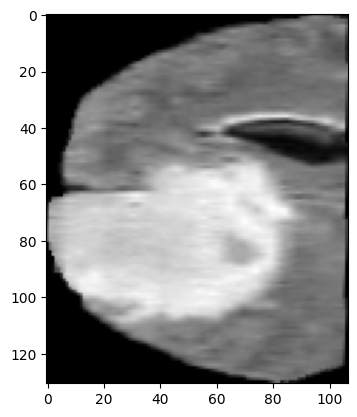

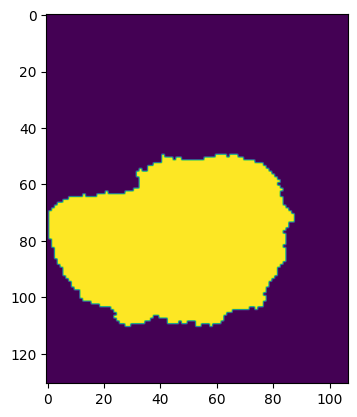

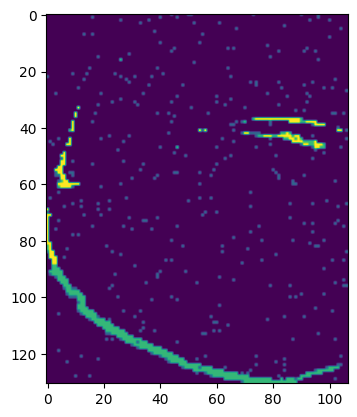

In [57]:
plt.imshow(cropped_images[0])
plt.show()
plt.imshow(cropped_masks[0])
plt.show()
plt.imshow(cropped_predictions[0])
plt.show()


In [ ]:
def get_predicted_mask(cropped_predictions,k,threshold=0.4):
    predcited_mask=[]
    for i in range(len(cropped_predictions[k])):
        temp=[]
        for j in cropped_predictions[k][i]:
            if j>threshold:
                temp.append(1)
            else:
                temp.append(0)
        predcited_mask.append(temp)
    return predcited_mask

In [ ]:
predcited_mask=[]
for i in range(len(cropped_predictions[0])):
    temp=[]
    for j in cropped_predictions[0][i]:
        if j>0.4:
            temp.append(1)
        else:
            temp.append(0)
    predcited_mask.append(temp)

In [ ]:
predcited_mask=get_predicted_mask(cropped_predictions,0,0.4)

In [ ]:
plt.imshow(predcited_mask)

In [ ]:
val, counts = np.unique(cropped_predictions[0], return_counts=True)
print(val)
print(counts)

In [ ]:
val, counts = np.unique(action_images[0], return_counts=True)
print(val)
print(counts)

In [ ]:
cropped_images,cropped_masks,cropped_predictions,cropped_bw_images=cropping([0],predicted_probs_images_test,X_test,y_test,bw_test,cushion=CUSHION)
state=get_state(100,100,cropped_predictions[0],cropped_bw_images[0])
action=dqn_solver.act(state)
action

In [ ]:
dqn_solver.model.Qpolicy.save_weights('RL_model_weights_500_2_0_4_multithreading')

In [ ]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice 

In [ ]:
DICE_COE(predcited_mask,cropped_masks[0])

In [ ]:
dice_scores=[]

In [ ]:
for i in range(len(cropped_predictions)):
    print(i)
    predcited_mask=get_predicted_mask(cropped_predictions,i,0.4)
    dice=DICE_COE(predcited_mask,cropped_masks[i])
    dice_scores.append(dice)

In [ ]:
dice_scores

In [ ]:
import pandas as pd
df=pd.DataFrame(dice_scores)
df.to_csv('RL_model_dice_scores_1000_1_0_4_0_4.csv')

In [ ]:
df

In [ ]:
plt.hist(dice_scores)

In [ ]:
df2=pd.read_csv(r'RL_model_dice_scores_250_4_0_4_0_4.csv')

In [ ]:
plt.hist(df2['0'][:50])

In [ ]:
count=0
for k in range(len(dqn_solver.memory)):
    if dqn_solver.memory[k][1]==0:
        count+=1
count